# Test data

This notebook exemplifies what occurs when the clean data used as reference for the [EEG Quality Index](../Functions/eeg_quality_index.py) is not detrended or high-pass filtered. 

The issue occurs if the clean data has drift of DC offsets that cause the zero-crossing rate yield to 0 values. The Z-scores are then calculated as:
$$ \text{Z}_\text{score} = \frac{x-\mu}{\sigma} $$

Where $x$ is the value of the quality index metric (e.g., zero-crossing rate) of the test dataset for each window, and $\mu$ and $\sigma$ are the mean and standard deviation of the same quality index metric of the clean dataset. As seen in the equation, if the zero-crossing rate only hace 0's, the standard deviation $\sigma$ would be 0. Thus, we would divide by 0 and get a `NaN` value result.

To demonstrate this, we will take some "clean" data with a lot of DC offset and compute the EEG Quality Index. Then, we will apply a high-pass filter to eliminate the DC.

## Import libraries

In [1]:
# Open plots in separate interactive window
%matplotlib qt

# Import libraries
import os
import mne
import sys
import pyxdf
import numpy as np
import scipy.fft as fft
import scipy.stats as stats
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import eeg_quality_index

## Import data

The clean dataset is in a `xdf` format which not native in MNE. Create an MNE object from the `xdf` data for easier plotting and filtering.

In [2]:
# Get data directory
current_directory = os.getcwd()
os.chdir("..")
data_folder = os.getcwd() + '\\Data\\'
os.chdir(current_directory)

# Create MNE object for XDF data
stream = 1  # Select proper stream from XDF file
streams, header = pyxdf.load_xdf(data_folder+'1Baseline_EZ.xdf')
sfreq = float(streams[stream]['info']['nominal_srate'][0])                  # Sampling frequency [Hz]
n_chans = len(streams[stream]['info']['desc'][0]['channels'][0]['channel']) # Number of channels [n]
chans = [streams[stream]['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(n_chans)]   # Channel names
info = mne.create_info(chans, sfreq, ch_types='eeg')
data = streams[stream]['time_series'].T # EEG data [uV]
clean = mne.io.RawArray(data*1e-6, info, verbose=False) # Create MNE object with proper scaling

# Import EDF data to MNE object
test = mne.io.read_raw_edf(data_folder+'2Baseline_EZ.edf', verbose=False)

## Plot clean dataset

Plot the clean dataset before applying the high-pass filter. 

Navigation tips:
- Use $+$ or $-$ to increase or decrease the vertical scale
- Use left or right arrows to control the horizontal sliding
- Use `d` to toggle DC-offset. 

Notice that with the DC-offset toggle, we can clearly see that the raw signals never cross the 0 line

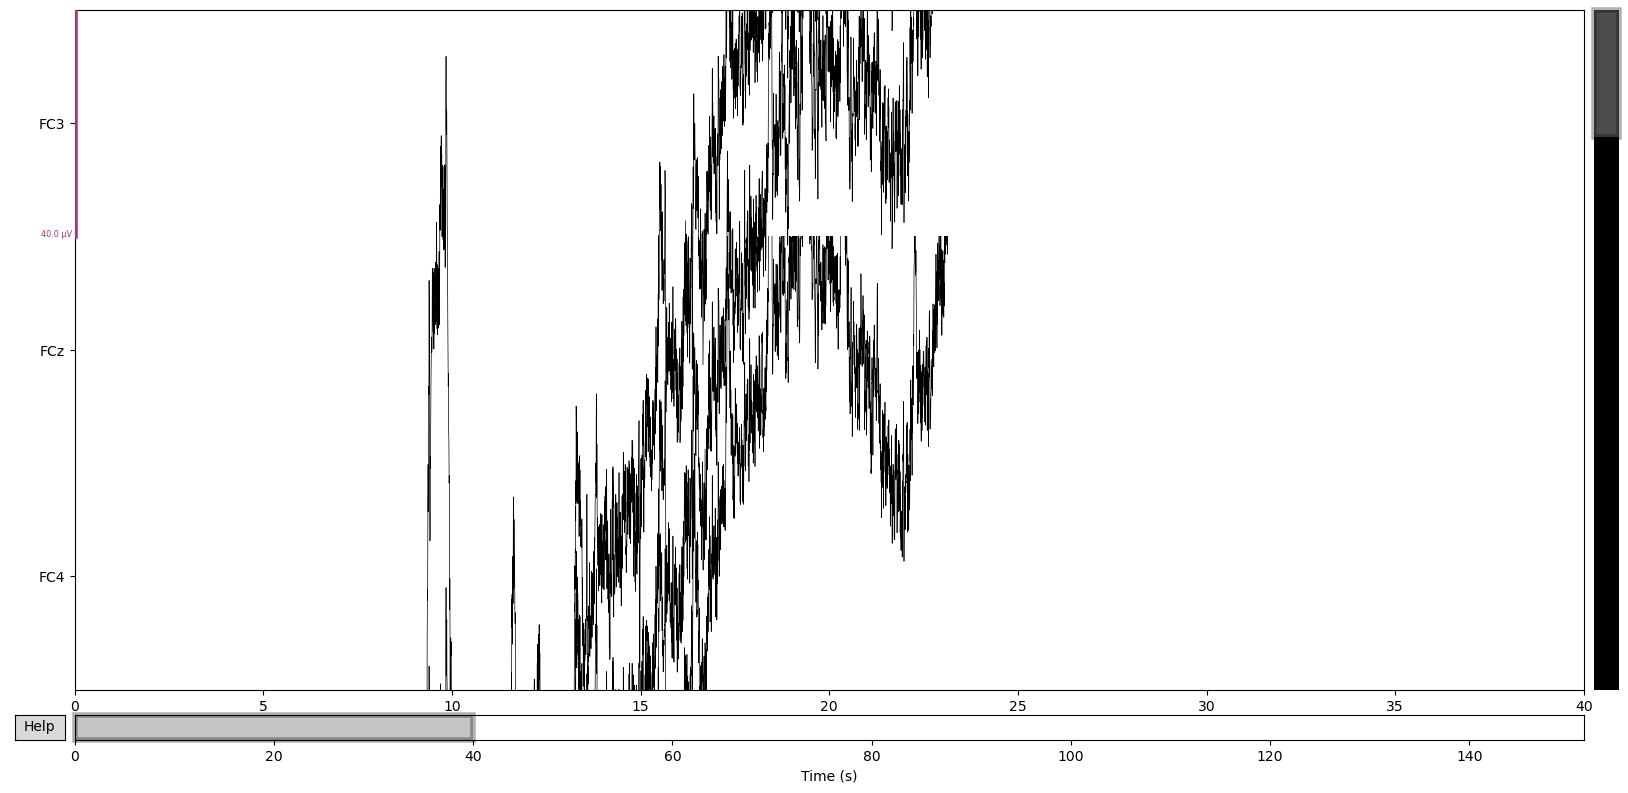

In [8]:
clean.plot(title='RAW', n_channels=3, duration=40)

## Run EEG Quality Index on RAW data

Run the EEG Quality Index on the RAW data. Notice how the tool reports that some variables have `NaN` values.

Printing the resulting matrix [EQI x channels] shows that the zero-crossing rate is the only variable with `Nan` values.

In [4]:
# Match channel order
clean_eeg = clean.get_data()
test_eeg = test.get_data(picks=range(np.size(clean_eeg,0))) # Cut size of test_eeg to channel number in clean_eeg

# Run EQI
eqi_results = eeg_quality_index.scoring(clean_eeg, test_eeg, srate_clean=int(clean.info['sfreq']),
    srate_test=int(test.info['sfreq']), window=int(sfreq), slide=10)

print(f'\nRaw data results\n{eqi_results[2]}')

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully

Raw data results
[[1.04356436 2.72554455 2.86825083 2.16673267 1.5770297  2.0089769
  2.22178218 1.71511551 2.79194719 2.56871287 1.12488449 2.38059406
  2.76541254 1.22877888 2.34917492 2.11762376]
 [1.26719472 1.9429703  2.55181518 1.99762376 1.32105611 2.43577558
  1.41584158 1.72739274 3.         1.50679868 1.80541254 1.56792079
  2.06547855 3.         1.32052805 1.00118812]
 [2.989967   2.99234323 2.99207921 2.99458746 2.99709571 2.99656766
  2.99841584 2.99353135 2.98957096 2.99537954 2.99432343 2.96382838
  3.         2.97716172 2.99115512 3.        ]
 [1.57056106 1.36673267 0.84118812 1.00752475 1.36079208 2.01808581
  1.37584158 1.57636964 1.36673267 0.73148515 1.33267327 1.20818482
  1.08448845 1.05254125 2.39194719 2.15115512]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        n

c:\Users\danie\Documents\Projects\EEG_quality_index\Notebooks\..\Functions\eeg_quality_index.py:69: RuntimeWarning: divide by zero encountered in true_divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\EEG_quality_index\Notebooks\..\Functions\eeg_quality_index.py:69: RuntimeWarning: invalid value encountered in true_divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


## Filter "clean" dataset

Now, apply a high-pass filter to the data and visualize it again. Notice how the DC-offset toggle does not do much change. This is because the high-pass filter already got rid of the DC components

In [5]:
# Apply hihg-pass filter
filtered = clean.copy()     # Copye clean to filtered MNE object
filtered = filtered.filter(l_freq=0.1, h_freq=None)


## Plot filtered data

Navigation tips:
- Use $+$ or $-$ to increase or decrease the vertical scale
- Use left or right arrows to control the horizontal sliding
- Use `d` to toggle DC-offset. 

Notice that with the DC-offset toggle there is no change in the signal.

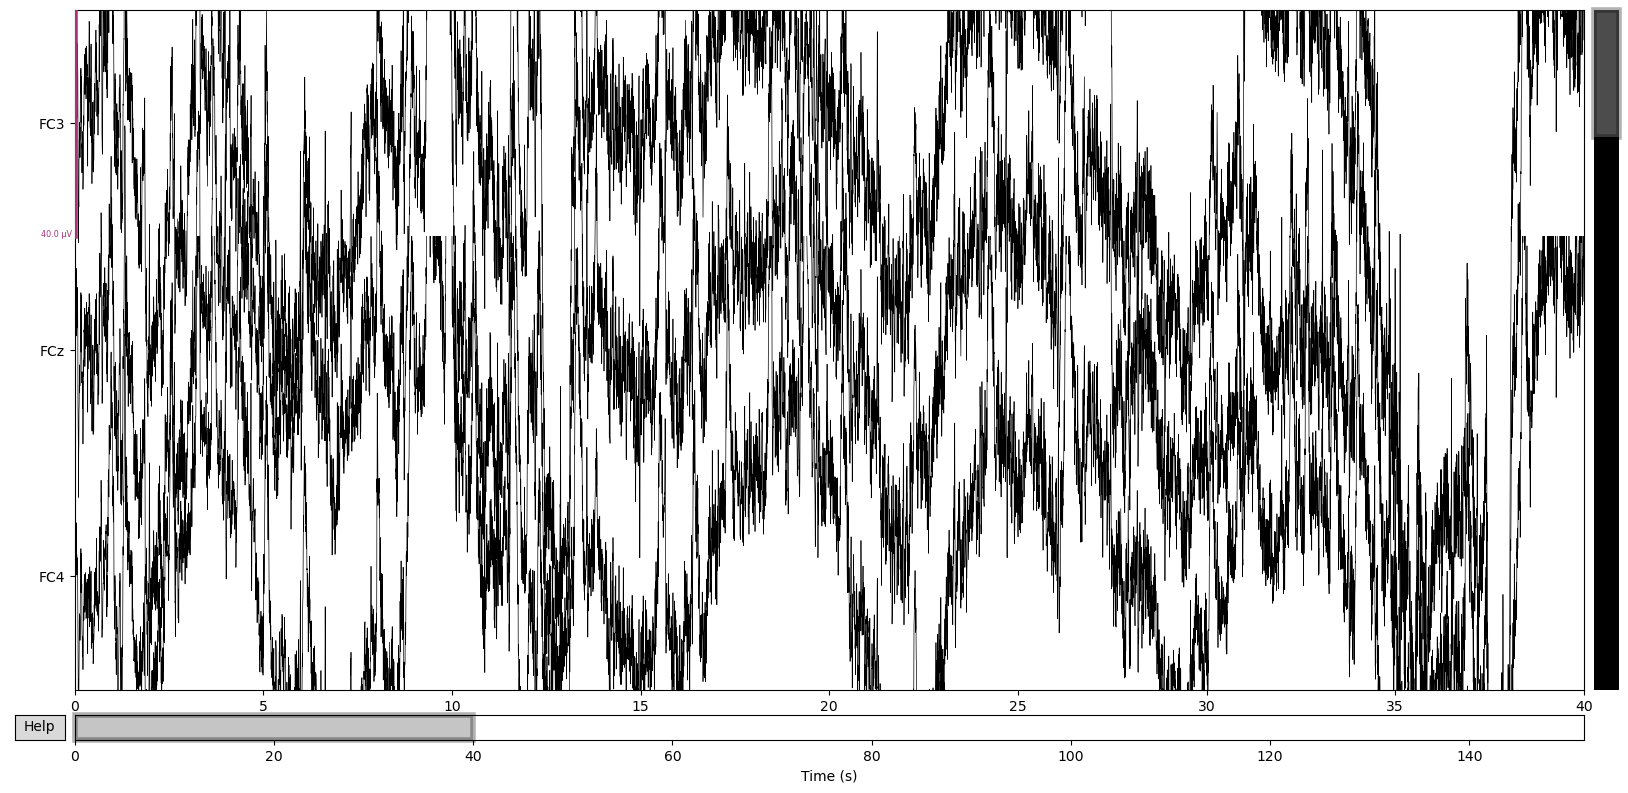

In [6]:
filtered.plot(title='Filtered', n_channels=3, duration=40)

## Run EEG Quality Index on filtered data

In [7]:
# Match channel order
filtered_eeg = filtered.get_data()
test_eeg = test.get_data(picks=range(np.size(filtered_eeg,0))) # Cut size of test_eeg to channel number in clean_eeg

eqi_results = eeg_quality_index.scoring(filtered_eeg, test_eeg, srate_clean=int(clean.info['sfreq']),
    srate_test=int(test.info['sfreq']), window=int(sfreq), slide=10)
# EEG Quality Index
